# The Real Difference Between Scaling, Normalization and Log Transformations with Sklearn
## Become a pro in preprocessing your numeric features
![](./images/pexels.jpg)
<figcaption style="text-align: center;">
    <strong>
        Photo by 
        <a href='https://www.pexels.com/@eye4dtail?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels'>George Becker</a>
        on 
        <a href='https://www.pexels.com/photo/grayscale-photography-of-three-wise-monkey-figurines-134402/?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels'>Pexels</a>
    </strong>
</figcaption>

### Setup

In [4]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

np.random.seed(1121218)
warnings.filterwarnings("ignore")

### What does it mean to conform to statistical approaches?

You have probably came across this in courses or articles: 

> The features in the dataset should conform to the statistical assumptions of the models.

What does it mean to conform to statistical assumptions? Many models implemented in Sklearn might perform poorly if the numeric features do not more or less follow a standard Gaussian (normal) distribution. With the exception of tree-based models, the objective function of Sklearn algorithms *assume* the features follow a normal distribution. 

Actually, using the word *assume* would be putting things lightly. For models like K-Nearest-Neighbors, feature transformation is a requirement for the algorithm to perform expectedly:

In [5]:
### HIDE
from sklearn.model_selection import train_test_split

ansur_num = (
    pd.read_csv("data/ansur_male.csv", encoding="latin")
    .select_dtypes(include="number")
    .drop("weightkg", axis=1)
)

X, y = ansur_num.iloc[:, :-1], ansur_num.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [6]:
from sklearn.neighbors import KNeighborsRegressor

# Before feature transforming
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)
print(
    "Test score of KNN before feature transformation: {}".format(
        knn.score(X_test, y_test)
    )
)

Test score of KNN before feature transformation: 0.8663552265106172


In [7]:
from sklearn.preprocessing import StandardScaler

# Transform
ss = StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

# After feature transforming
knn = KNeighborsRegressor()
knn.fit(X_train_scaled, y_train)
print(
    "Test score of KNN after feature transformation: {}".format(
        knn.score(X_test_scaled, y_test)
    )
)

Test score of KNN after feature transformation: 0.9166671893134017


In practice, you may even face scenarios where feature transformations have even larger effect than 5% increase in performance.

There are many techniques you can apply to make your features more or less follow a normal distribution. They differ based on the underlying distributions of each feature. 

In this article, you will learn about 4 of such techniques: Scaling, normalization, logarithmic tranformers and outlier-based scaling. You will develop a practical understanding of their differences and when to apply them in your own workflow.

### Identifying the Underlying Distribution of Features

Before applying any of the techniques you will be learning, it is important to visually explore each feature. You don't have to create perfect plots, simple histograms and boxplots with default styles will be enough to identify distributions. Take a look at these histograms from the Diamonds dataset of Seaborn:

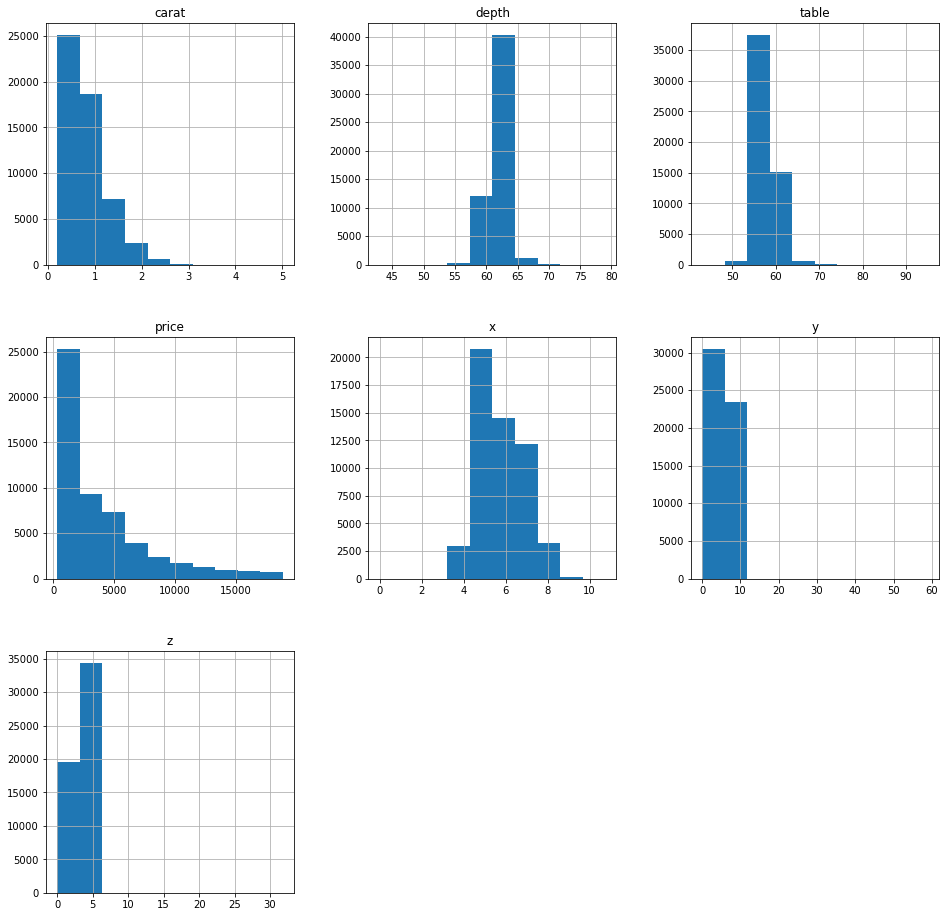

In [11]:
diamonds = sns.load_dataset("diamonds")

diamonds.hist(figsize=(16, 16));

Pay close attention to the shape of the distributions and the ranges on the X axes. From the subplots, we can see that price and carat features follow a skewed distribution. Depth, table and *x* may remotely resemble a normal distribution. 

Apart from the distributions, the range of values is also an important aspect of features. Boxplots are best at showing this using the 5-figure summary:

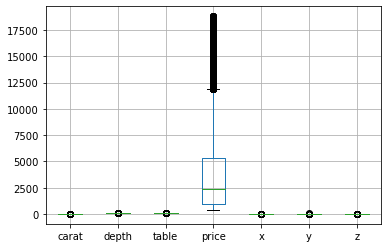

In [14]:
diamonds.boxplot();

The above plot is enough to tell us that the features in the diamonds dataset have very different scales. As diamond prices have a larger scale of values, they squished other plots into a line. Here is the 5-figure summary for further comparison:

In [19]:
diamonds.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
carat,53940.0,0.80,0.47,0.2,0.40,0.70,1.04,5.01
depth,53940.0,61.75,1.43,43.0,61.00,61.80,62.50,79.00
table,53940.0,57.46,2.23,43.0,56.00,57.00,59.00,95.00
price,53940.0,3932.80,3989.44,326.0,950.00,2401.00,5324.25,18823.00
x,53940.0,5.73,1.12,0.0,4.71,5.70,6.54,10.74
y,53940.0,5.73,1.14,0.0,4.72,5.71,6.54,58.90
z,53940.0,3.54,0.71,0.0,2.91,3.53,4.04,31.80


Now that you learned how to identify the shape of the distributions and the difference of each feature's scale, by the end of the article we will have made all features have the same scale and more or less follow a normal distribution like so:

In [ ]:
#### TODO